# Introduction
Once upon a time, there was a bank offering services to private persons. The services include managing of accounts, offering loans, etc. The bank wants to improve their services by finding interesting groups of clients (e.g. to differentiate between good and bad clients). The bank managers have only vague idea, who is good client (whom to offer some additional services) and who is bad client (whom to watch carefully to minimize the bank looses). Fortunately, the bank stores data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued So the bank managers hope to find some answers (and questions as well) by analyzing this data. 
In this kernel, I am going to follow the basic process of loan default prediction with machine learning algorithms.
## Task description
In this data challenge, I'm going to work with 8 datasets from the bank (dataset was collected from year of 1999). As a data scientist, we will need to perform the following tasks:
* Use Python to connect to files and read tables into Pandas dataframes
* Preprocess data for machine learning
* Train a ML model to predict customers who are more likely to default on loans
* Evaluate model performance
* Try to understand the key predictors of default

# Exploratory Analysis
To begin this exploratory analysis, first import libraries and prepare the data. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from datetime import datetime, date, time, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import svm
plt.style.use('ggplot')

# Data Preparation

## Import and Update tables

In [2]:
# import and update table card
card = pd.read_csv(
    "input/card.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
card.issued = card.issued.str.strip("00:00:00")
card.type = card.type.map({"gold": 2, "classic": 1, "junior": 0})
card.head()


,card_id,disp_id,type,issued
0,1005,9285,1,931107
1,104,588,1,940119
2,747,4915,1,940205
3,70,439,1,940208
4,577,3687,1,940215


In [3]:
# import and update table account
account = pd.read_csv(
    "input/account.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
)
account.date = account.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
account.head()


,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,1993-01-01
1,3818,74,POPLATEK MESICNE,1993-01-01
2,704,55,POPLATEK MESICNE,1993-01-01
3,2378,16,POPLATEK MESICNE,1993-01-01
4,2632,24,POPLATEK MESICNE,1993-01-02


In [4]:
# import and update table disp
disp = pd.read_csv(
    "input/disp.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
disp = disp[disp.type == "OWNER"]
disp.rename(columns={"type": "type_disp"}, inplace=True)
disp.head()


,disp_id,client_id,account_id,type_disp
0,1,1,1,OWNER
1,2,2,2,OWNER
3,4,4,3,OWNER
5,6,6,4,OWNER
6,7,7,5,OWNER


In [5]:
# import and update table client
client = pd.read_csv(
    "input/client.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
client["month"] = client.birth_number.apply(
    lambda x: x // 100 % 100, convert_dtype=True, args=()
)
client["year"] = client.birth_number.apply(
    lambda x: x // 100 // 100, convert_dtype=True, args=()
)
client["age"] = 99 - client.year
client["sex"] = client.month.apply(lambda x: (x - 50) < 0, convert_dtype=True, args=())
client.sex = client.sex.astype(int)  # 0 for female, 1 for male
client.drop(["birth_number", "month", "year"], axis=1, inplace=True)
client.head()


,client_id,district_id,age,sex
0,1,18,29,0
1,2,1,54,1
2,3,1,59,0
3,4,5,43,1
4,5,5,39,0


In [6]:
# import and update table district
district = pd.read_csv(
    "input/district.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
district.drop(["A2", "A3"], axis=1, inplace=True)
district.head()


,A1,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


In [7]:
# import and update table order
order = pd.read_csv(
    "input/order.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
order.drop(["bank_to", "account_to", "order_id"], axis=1, inplace=True)
order.k_symbol.fillna("No_symbol")
order.k_symbol = order.k_symbol.str.replace(" ", "No_symbol")
order = order.groupby(["account_id", "k_symbol"]).mean().unstack()
order = order.fillna(0)
order.columns = order.columns.droplevel()
order.reset_index(level="account_id", col_level=1, inplace=True)
order.rename_axis("", axis="columns", inplace=True)
order.rename(
    index=None,
    columns={
        "LEASING": "order_amount_LEASING",
        "No_symbol": "order_amount_No_symbol",
        "POJISTNE": "order_amount_POJISTNE",
        "SIPO": "order_amount_SIPO",
        "UVER": "order_amount_UVER",
    },
    inplace=True,
)
order.head()


,account_id,order_amount_LEASING,order_amount_No_symbol,order_amount_POJISTNE,order_amount_SIPO,order_amount_UVER
0,1,0.0,0.0,0.0,2452.0,0.0
1,2,0.0,0.0,0.0,7266.0,3372.7
2,3,0.0,327.0,3539.0,1135.0,0.0
3,4,0.0,0.0,0.0,1681.5,0.0
4,5,0.0,0.0,0.0,2668.0,0.0


In [8]:
# import and update table loan
loan = pd.read_csv(
    "input/loan.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
loan.date = loan.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
loan.head()


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


In [9]:
# import and update table trans
trans = pd.read_csv(
    "input/trans.asc",
    sep=";",
    delimiter=None,
    header="infer",
    names=None,
    low_memory=False,
)
trans.loc[trans.k_symbol == "", "k_symbol"] = trans[
    trans.k_symbol == ""
].k_symbol.apply(lambda x: "k_symbol_missing")
trans.loc[trans.k_symbol == " ", "k_symbol"] = trans[
    trans.k_symbol == " "
].k_symbol.apply(lambda x: "k_symbol_missing")
loan_account_id = loan.loc[:, ["account_id"]]
trans = loan_account_id.merge(trans, how="left", on="account_id")
trans.date = trans.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
trans.head()


,account_id,trans_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1787,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN
1,1787,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN
2,1787,524055,1993-05-21,PRIJEM,VKLAD,5800.0,16800.0,NaN,NaN,NaN
3,1787,524056,1993-06-20,PRIJEM,VKLAD,3300.0,20100.0,NaN,NaN,NaN
4,1787,523624,1993-07-08,PRIJEM,VKLAD,42248.0,62348.0,NaN,NaN,NaN


In [10]:
# create temp table trans_pv_k_symbol
trans_pv_k_symbol = trans.pivot_table(
    values=["amount", "balance"], index=["trans_id"], columns="k_symbol"
)
trans_pv_k_symbol.fillna(0, inplace=True)
trans_pv_k_symbol.columns = ["_".join(col) for col in trans_pv_k_symbol.columns]
trans_pv_k_symbol = trans_pv_k_symbol.reset_index()
trans_pv_k_symbol = trans.iloc[:, :3].merge(
    trans_pv_k_symbol, how="left", on="trans_id"
)
trans_pv_k_symbol.head()


,account_id,trans_id,date,amount_POJISTNE,amount_SANKC. UROK,amount_SIPO,amount_SLUZBY,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,1787,523621,1993-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1787,524054,1993-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1787,524055,1993-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1787,524056,1993-06-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1787,523624,1993-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# create temp table get_date_loan_trans
get_date_loan_trans = pd.merge(
    loan,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
get_date_loan_trans = pd.merge(
    get_date_loan_trans,
    trans,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_account", "_trans"),
    copy=True,
    indicator=False,
    validate=None,
)


In [12]:
# update table get_date_loan_trans to get the date between loan_date and trans_date.
get_date_loan_trans["date_loan_trans"] = (
    get_date_loan_trans.date_loan - get_date_loan_trans.date
)
get_date_loan_trans[["date_loan_trans"]] = get_date_loan_trans[
    ["date_loan_trans"]
].astype(str)
get_date_loan_trans.date_loan_trans = get_date_loan_trans.date_loan_trans.str.strip(
    " days 00:00:00.000000000"
)
get_date_loan_trans.date_loan_trans = pd.to_numeric(
    get_date_loan_trans.date_loan_trans.str.strip(" days +")
)
get_date_loan_trans.head()


,loan_id,account_id,date_loan,amount_account,duration,payments,status,district_id,frequency,date_account,trans_id,date,type,operation,amount_trans,balance,k_symbol,bank,account,date_loan_trans
0,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523621,1993-03-22,PRIJEM,VKLAD,1100.0,1100.0,NaN,NaN,NaN,105.0
1,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524054,1993-04-21,PRIJEM,VKLAD,9900.0,11000.0,NaN,NaN,NaN,75.0
2,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524055,1993-05-21,PRIJEM,VKLAD,5800.0,16800.0,NaN,NaN,NaN,45.0
3,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,524056,1993-06-20,PRIJEM,VKLAD,3300.0,20100.0,NaN,NaN,NaN,15.0
4,5314,1787,1993-07-05,96396,12,8033.0,B,30,POPLATEK TYDNE,1993-03-22,523624,1993-07-08,PRIJEM,VKLAD,42248.0,62348.0,NaN,NaN,NaN,-3.0


In [13]:
# create temp table temp_90_mean to create new feature
temp_90_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 90)
]
temp_90_mean = temp_90_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_90_mean = temp_90_mean.groupby(["loan_id"], as_index=None).mean()
temp_90_mean = temp_90_mean.loc[:, ["loan_id", "balance"]]
temp_90_mean.rename(
    index=None, columns={"balance": "avg_balance_3M_befroe_loan"}, inplace=True
)


C:\Users\colle\AppData\Local\Temp\ipykernel_26928\3384386953.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_90_mean = temp_90_mean.groupby(["loan_id"], as_index=None).mean()


In [14]:
# create temp table temp_30_mean to create new feature
temp_30_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 30)
]
temp_30_mean = temp_30_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_30_mean = temp_30_mean.groupby(["loan_id"], as_index=None).mean()
temp_30_mean = temp_30_mean.loc[:, ["loan_id", "balance"]]
temp_30_mean.rename(
    index=None, columns={"balance": "avg_balance_1M_befroe_loan"}, inplace=True
)


C:\Users\colle\AppData\Local\Temp\ipykernel_26928\4018490980.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_30_mean = temp_30_mean.groupby(["loan_id"], as_index=None).mean()


In [15]:
# create temp table temp_trans_freq to create new feature
temp_before = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
temp_trans_freq = (
    temp_before.loc[:, ["loan_id", "trans_id"]]
    .groupby(["loan_id"], as_index=None)
    .count()
)
temp_trans_freq.rename(index=None, columns={"trans_id": "trans_freq"}, inplace=True)
temp_before = temp_before.drop(["trans_id", "k_symbol"], axis=1)


In [16]:
# create temp table temp_balance_min & temp_balance_mean to create new features
temp_balance_min = (
    temp_before.groupby(["loan_id"], as_index=None).min().loc[:, ["loan_id", "balance"]]
)
temp_balance_min.rename(
    index=None, columns={"balance": "min_balance_befroe_loan"}, inplace=True
)

temp_balance_mean = (
    temp_before.groupby(["loan_id"], as_index=None)
    .mean()
    .loc[:, ["loan_id", "amount_trans", "balance"]]
)
temp_balance_mean.rename(
    index=None,
    columns={
        "amount_trans": "avg_amount_trans_before_loan",
        "balance": "avg_balance_before_loan",
    },
    inplace=True,
)


C:\Users\colle\AppData\Local\Temp\ipykernel_26928\601546438.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  temp_before.groupby(["loan_id"], as_index=None).min().loc[:, ["loan_id", "balance"]]
C:\Users\colle\AppData\Local\Temp\ipykernel_26928\601546438.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


In [17]:
    # create temp table times_balance_below_500 & times_balance_below_5K to create new features
    times_balance_below_500 = temp_before[temp_before.balance < 500]
    times_balance_below_500 = (
        times_balance_below_500.groupby(["loan_id"], as_index=None)
        .count()
        .loc[:, ["loan_id", "balance"]]
    )
    times_balance_below_500 = times_balance_below_500[times_balance_below_500.balance > 1]
    times_balance_below_500.rename(
        index=str, columns={"balance": "times_balance_below_500"}, inplace=True
    )

    times_balance_below_5K = temp_before[temp_before.balance < 5000]
    times_balance_below_5K = (
        times_balance_below_5K.groupby(["loan_id"], as_index=None)
        .count()
        .loc[:, ["loan_id", "balance"]]
    )
    times_balance_below_5K = times_balance_below_5K[times_balance_below_5K.balance > 1]
    times_balance_below_5K.rename(
        index=str, columns={"balance": "times_balance_below_5K"}, inplace=True
    )


In [18]:
# create temp table merge_loan_trans to merge the temp features above into one temp table
merge_loan_trans = loan.merge(
    temp_90_mean, how="left", on="loan_id", suffixes=("_loan", "_trans")
)
merge_loan_trans = merge_loan_trans.merge(temp_30_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_trans_freq, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_min, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_500, how="left", on="loan_id"
)
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_5K, how="left", on="loan_id"
)


In [19]:
loan_BorD = loan[(loan.status == "D") | (loan.status == "B")]
len(loan_BorD)


76

In [20]:
temp = times_balance_below_500.merge(
    loan,
    how="inner",
    on="loan_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

temp.status.value_counts()


D    17
B     7
A     2
Name: status, dtype: int64

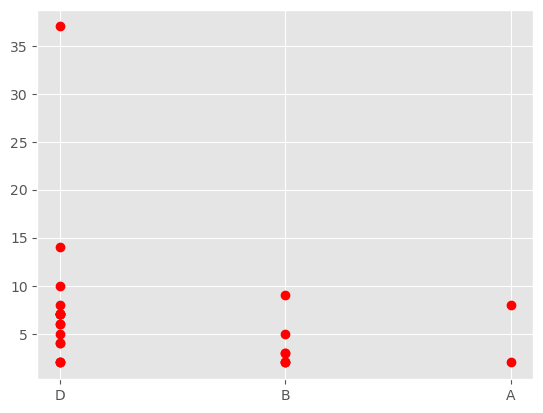

In [21]:
plt.plot(temp.status, temp.times_balance_below_500, "ro")


<Axes: xlabel='status'>

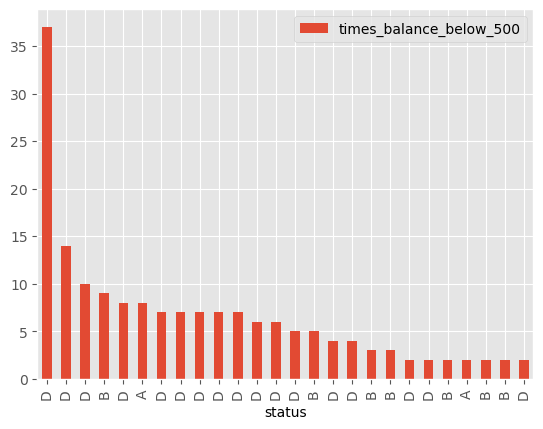

In [22]:
temp.sort_values("times_balance_below_500", ascending=False).plot(
    x="status", y="times_balance_below_500", kind="bar"
)


In [23]:
t = loan.loc[:, ["payments", "status"]]
t.head(3)


,payments,status
0,8033.0,B
1,4610.0,A
2,2118.0,A


<Axes: >

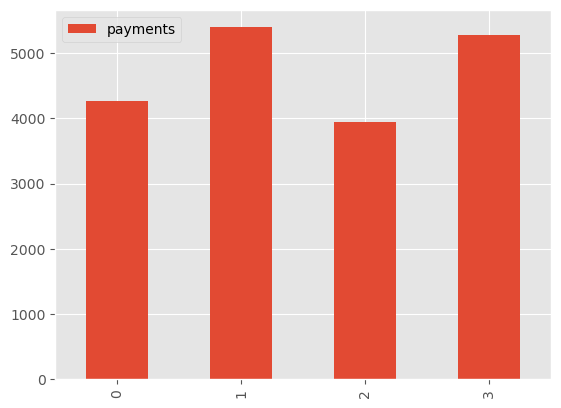

In [24]:
t = t.groupby(["status"], as_index=None).mean()
t.plot(kind="bar")


# Merge tables

In [25]:
df = pd.merge(
    merge_loan_trans,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)


In [26]:
df = pd.merge(
    df,
    order,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_a", "_order"),
    copy=True,
    indicator=False,
    validate=None,
)


In [27]:
df = pd.merge(
    df,
    disp,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_b", "_disp"),
    copy=True,
    indicator=False,
    validate=None,
)


In [28]:
df = pd.merge(
    df,
    card,
    how="left",
    on="disp_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_c", "_card"),
    copy=True,
    indicator=False,
    validate=None,
)


In [29]:
df = pd.merge(
    df,
    client,
    how="left",
    on="client_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_d", "_client"),
    copy=True,
    indicator=False,
    validate=None,
)


In [30]:
df = pd.merge(
    df,
    district,
    how="left",
    left_on="district_id_client",
    right_on="A1",
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_e", "_district"),
    copy=True,
    indicator=False,
    validate=None,
)


In [31]:
before_loan_date = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
before_loan_date = before_loan_date.loc[:, ["account_id", "trans_id"]]
trans_pv_k_symbol = pd.merge(
    before_loan_date,
    trans_pv_k_symbol,
    how="left",
    on="trans_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_before", "_df2"),
    copy=True,
    indicator=False,
    validate=None,
)
trans_pv_k_symbol.drop(
    ["account_id_df2", "date", "trans_id"], axis=1, inplace=True
)
trans_pv_k_symbol.rename(columns={"account_id_before": "account_id"}, inplace=True)
trans_pv_k_symbol = trans_pv_k_symbol.groupby(
    by="account_id", axis=0, as_index=False, sort=True, group_keys=True, squeeze=False
).mean()


C:\Users\colle\AppData\Local\Temp\ipykernel_26928\2960293958.py:22: FutureWarning: The `squeeze` parameter is deprecated and will be removed in a future version.
  trans_pv_k_symbol = trans_pv_k_symbol.groupby(


In [32]:
df = pd.merge(
    df,
    trans_pv_k_symbol,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_df", "_tt"),
    copy=True,
    indicator=False,
    validate=None,
)


# Data Cleaning

In [33]:
df["year_"] = df.date_loan.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_loan"] = 1999 - df.year_
df.drop(["date_loan", "year_"], axis=1, inplace=True)
df.frequency = df.frequency.map(
    {"POPLATEK MESICNE": 30, "POPLATEK TYDNE": 7, "POPLATEK PO OBRATU": 1}
)


In [34]:
df["year_"] = df.date_account.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_account"] = 1999 - df.year_
df.drop(["date_account", "year_", "type_disp"], axis=1, inplace=True)


In [35]:
df.issued.fillna("999999", inplace=True)
df["years_card_issued"] = df.issued.apply(
    lambda x: (99 - int(x[:2])), convert_dtype=int
)
df.drop(["issued","A12","A15"], axis=1, inplace=True)


In [36]:
df.fillna(0, inplace=True)


In [37]:
df.status.value_counts()


C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [38]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_id                       682 non-null    int64  
 1   account_id                    682 non-null    int64  
 2   amount                        682 non-null    int64  
 3   duration                      682 non-null    int64  
 4   payments                      682 non-null    float64
 5   status                        682 non-null    object 
 6   avg_balance_3M_befroe_loan    682 non-null    float64
 7   avg_balance_1M_befroe_loan    682 non-null    float64
 8   trans_freq                    682 non-null    int64  
 9   min_balance_befroe_loan       682 non-null    float64
 10  avg_amount_trans_before_loan  682 non-null    float64
 11  avg_balance_before_loan       682 non-null    float64
 12  times_balance_below_500       682 non-null    float64
 13  times

# Get label

In [39]:
m = {"A": 0, "B": 1, "C": 0, "D": 1}
df.status = df.status.map(m)
df.status.unique()


array([1, 0], dtype=int64)

In [40]:
df = pd.get_dummies(df, drop_first=True)


In [41]:
    df.columns.unique()

Index(['loan_id', 'account_id', 'amount', 'duration', 'payments', 'status',
       'avg_balance_3M_befroe_loan', 'avg_balance_1M_befroe_loan',
       'trans_freq', 'min_balance_befroe_loan', 'avg_amount_trans_before_loan',
       'avg_balance_before_loan', 'times_balance_below_500',
       'times_balance_below_5K', 'district_id_d', 'frequency',
       'order_amount_LEASING', 'order_amount_No_symbol',
       'order_amount_POJISTNE', 'order_amount_SIPO', 'order_amount_UVER',
       'disp_id', 'client_id', 'card_id', 'type', 'district_id_client', 'age',
       'sex', 'A1', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A13',
       'A14', 'A16', 'amount_POJISTNE', 'amount_SANKC. UROK', 'amount_SIPO',
       'amount_SLUZBY', 'amount_UROK', 'amount_UVER',
       'amount_k_symbol_missing', 'balance_POJISTNE', 'balance_SANKC. UROK',
       'balance_SIPO', 'balance_SLUZBY', 'balance_UROK', 'balance_UVER',
       'balance_k_symbol_missing', 'years_of_loan', 'years_of_account',
       'years

In [42]:
df.drop(
    [
        "loan_id",
        "account_id",
        "district_id_d",
        "disp_id",
        "client_id",
        "card_id",
        "district_id_client",
    ],
    axis=1,
    inplace=True,
)


# Standard processing and Training/Test set Split

In [43]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Model Evaluation

# Draft Modeling: Random Forest

In [44]:
rf = ensemble.RandomForestClassifier(
    n_estimators=200,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


c:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [45]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       188
           1       1.00      0.53      0.69        17

    accuracy                           0.96       205
   macro avg       0.98      0.76      0.84       205
weighted avg       0.96      0.96      0.96       205



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

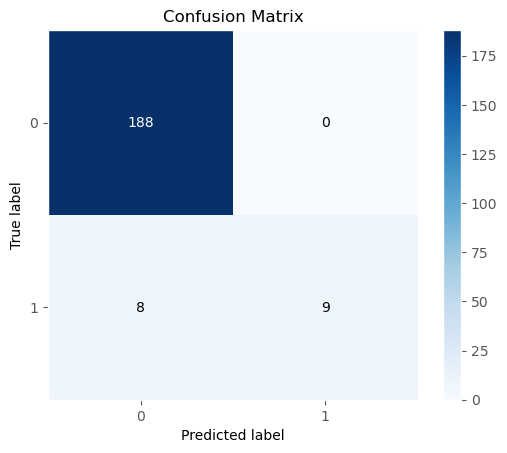

In [46]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


In [47]:
fi = rf.feature_importances_


In [48]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)


<Axes: xlabel='feature'>

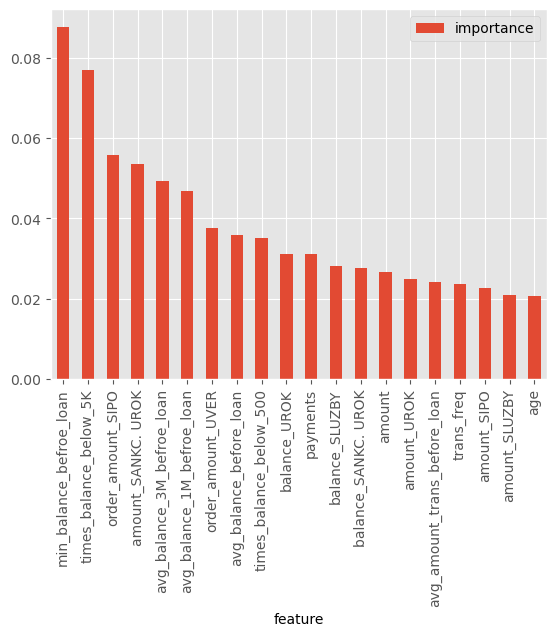

In [49]:
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:20].plot(x="feature", y="importance", kind="bar")


# Visualization & Feature Selection

C:\Users\colle\AppData\Local\Temp\ipykernel_26928\1166414914.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df.groupby(["sex", "status"])["status"].size().groupby(level=0).apply(


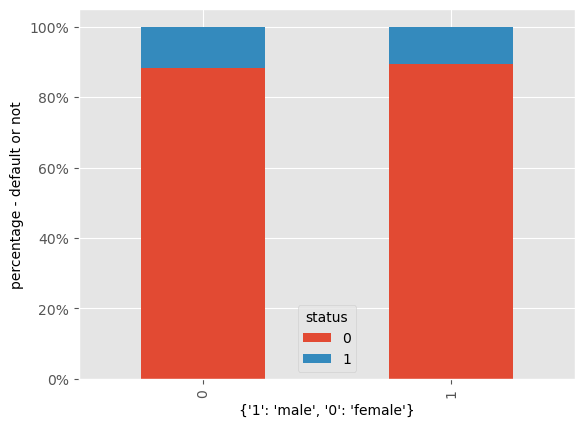

In [50]:
df.groupby(["sex", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.xlabel({"1": "male", "0": "female"})
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()


In [51]:
df.groupby(["sex", "status"])["status"].size()


sex  status
0    0         307
     1          41
1    0         299
     1          35
Name: status, dtype: int64

C:\Users\colle\AppData\Local\Temp\ipykernel_26928\3818875961.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df.groupby(["age", "status"])["status"].size().groupby(level=0).apply(


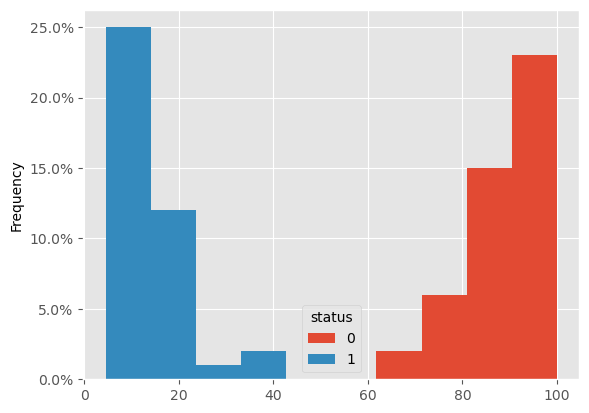

In [52]:
df.groupby(["age", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="hist", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()


C:\Users\colle\AppData\Local\Temp\ipykernel_26928\2783174253.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind="bar", stacked=True)


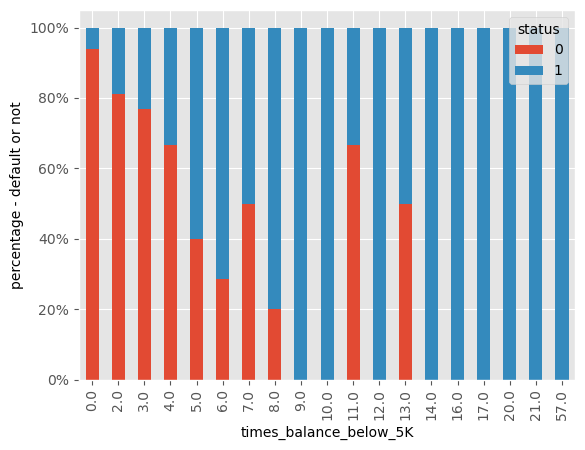

In [53]:
df.groupby(["times_balance_below_5K", "status"])["status"].size().groupby(
    level=0
).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()


C:\Users\colle\AppData\Local\Temp\ipykernel_26928\838545473.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df.groupby(["years_card_issued", "status"])["status"].size().groupby(level=0).apply(


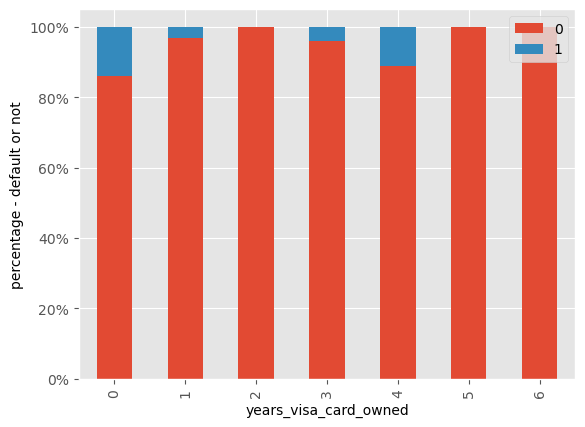

In [54]:
df.groupby(["years_card_issued", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.xlabel("years_visa_card_owned")
plt.legend(loc=1)
plt.show()


Text(0, 0.5, 'count_of_loan_id')

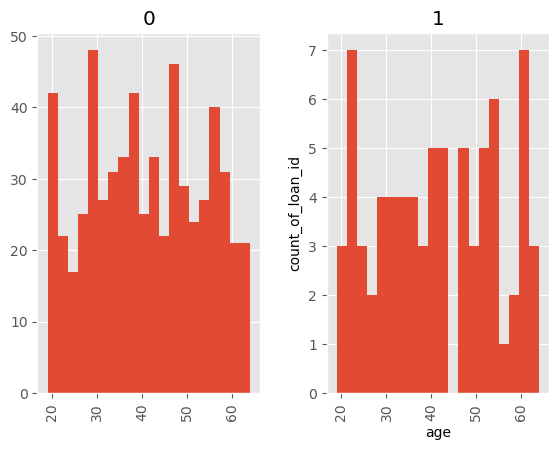

In [55]:
df.hist(column="age", by="status", bins=20)
plt.xlabel("age")
plt.ylabel("count_of_loan_id")


In [56]:
# Binning:
def binning(col, cut_points, labels=None):
    # Define min and max values:
    minval = col.min()
    maxval = col.max()

    # create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    # if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points) + 1)

    # Binning using cut function of pandas
    colBin = pd.cut(col, bins=break_points, labels=labels, include_lowest=True)
    return colBin


# Binning age:
cut_points = [24, 34, 44, 50]
labels = ["20", "25", "35", "45", "50"]
df["age_bin"] = binning(df["age"], cut_points, labels)


C:\Users\colle\AppData\Local\Temp\ipykernel_26928\917702318.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df.groupby(["age_bin", "status"])["status"].size().groupby(level=0).apply(


Text(0, 0.5, 'percentage - default or not')

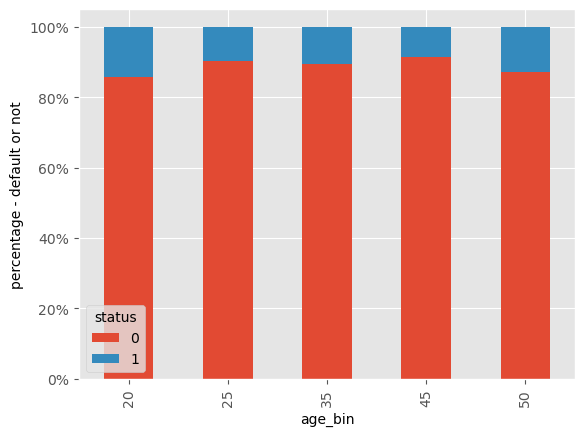

In [57]:
df.groupby(["age_bin", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylabel("percentage - default or not")


In [58]:
df[df.status == 1].head()


,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,avg_balance_before_loan,...,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued,age_bin
0,96396,12,8033.0,1,15966.666667,20100.000000,4,1100.0,5025.000000,12250.000000,...,0.0,0.000,0.000000,0.000000,0.0,0.000,6,6,0,50
7,174744,24,7281.0,1,21443.410526,26301.042857,32,1000.0,11557.950000,37485.456250,...,0.0,8350.400,4795.233333,20643.941667,0.0,0.000,6,6,0,50
12,464520,60,7742.0,1,43137.355556,62808.846154,68,200.0,13335.798529,51760.016176,...,0.0,0.000,21409.662500,27223.631250,0.0,0.000,6,6,0,50
19,75624,24,3151.0,1,55333.050000,57562.000000,23,400.0,13406.739130,50009.908696,...,0.0,4195.480,0.000000,45769.340000,0.0,0.000,6,6,0,35
28,49320,12,4110.0,1,44874.806452,40374.653846,49,900.0,10548.359184,46576.277551,...,0.0,9223.925,12802.725000,13012.725000,0.0,8296.075,5,6,0,50


Text(0, 0.5, 'payments')

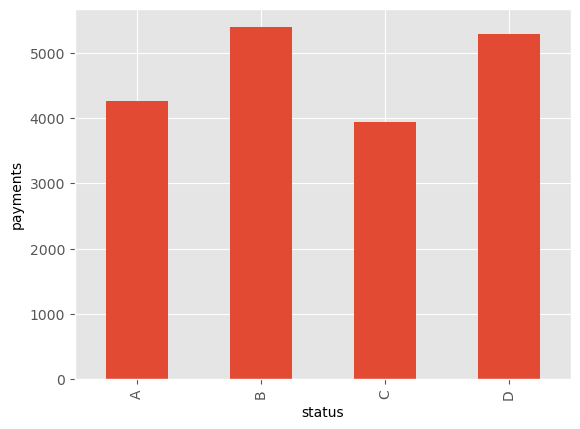

In [59]:
a = loan.groupby(
    by="status", axis=0, level=None, as_index=True, sort=True, group_keys=True
)
a.payments.mean().plot(kind="bar")
plt.ylabel("payments")


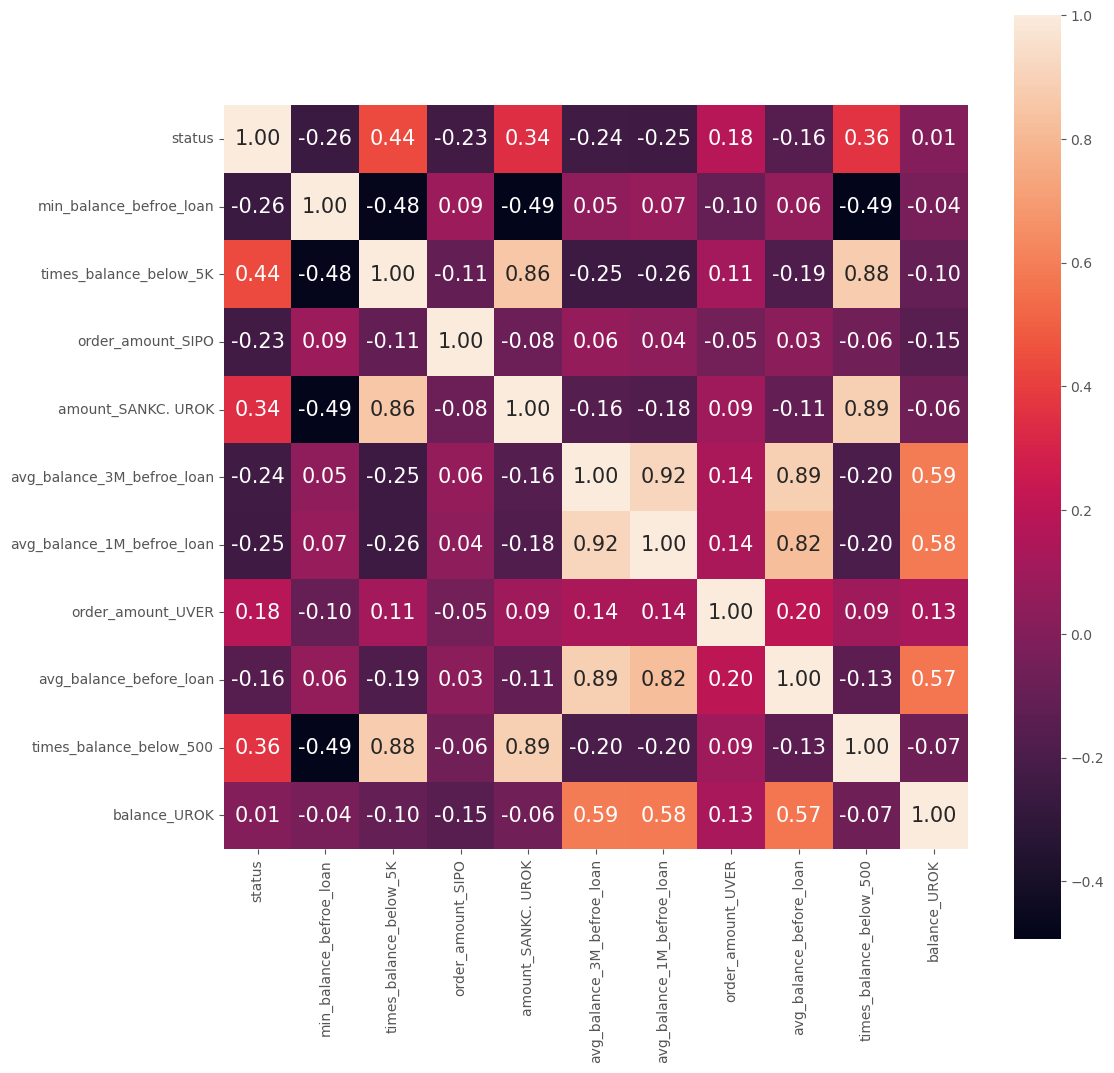

In [60]:
# plot heatmap
import seaborn as sns

cols = list(importance.feature[:10])
cols.insert(0, "status")
corrcoef_map = np.corrcoef(df[cols].values.T)
fig, ax = plt.subplots(figsize=(12, 12))  # Sample figsize in inches
hm = sns.heatmap(
    corrcoef_map,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 15},
    yticklabels=cols,
    xticklabels=cols,
    ax=ax,
)


# Create X, y, training/testing set split

In [61]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Modeling: Random Forest

In [62]:
rf = ensemble.RandomForestClassifier(
    n_estimators=800,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


c:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [63]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96       183
           1       1.00      0.36      0.53        22

    accuracy                           0.93       205
   macro avg       0.96      0.68      0.75       205
weighted avg       0.94      0.93      0.92       205



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

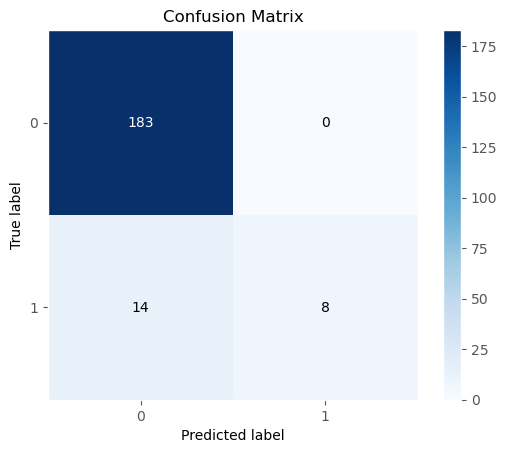

In [64]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


In [65]:
fi = rf.feature_importances_


In [66]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)


Text(0, 0.5, 'importance')

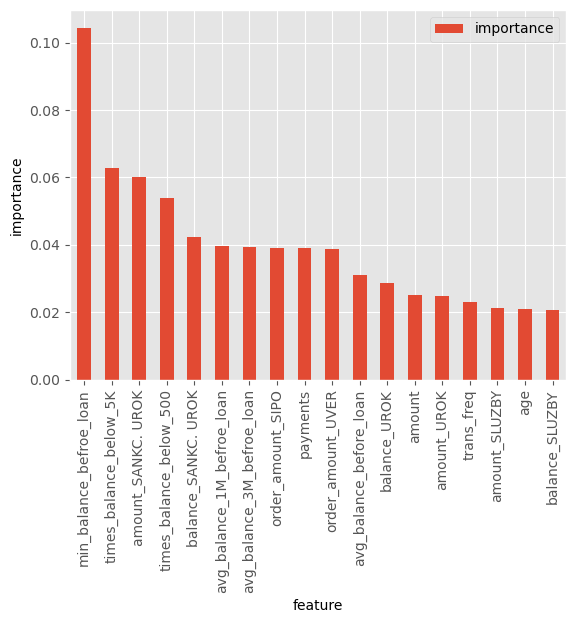

In [67]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")
plt.ylabel("importance")


# Decision Tree

In [69]:
clf = tree.DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
)

model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [70]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       183
           1       0.57      0.59      0.58        22

    accuracy                           0.91       205
   macro avg       0.76      0.77      0.76       205
weighted avg       0.91      0.91      0.91       205



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

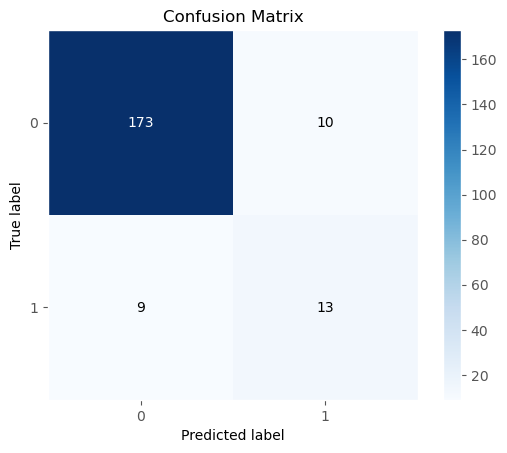

In [71]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


<Axes: xlabel='feature'>

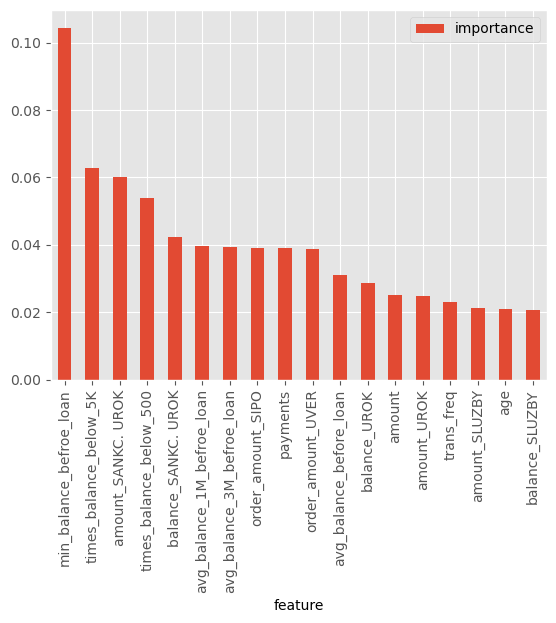

In [72]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")


# Gradient Boosting Classifier

In [73]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(
    loss="deviance",
    learning_rate=0.1,
    n_estimators=200,
    subsample=1.0,
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    init=None,
    random_state=None,
    max_features=None,
)
model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


c:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


In [74]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       183
           1       0.89      0.36      0.52        22

    accuracy                           0.93       205
   macro avg       0.91      0.68      0.74       205
weighted avg       0.92      0.93      0.91       205



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

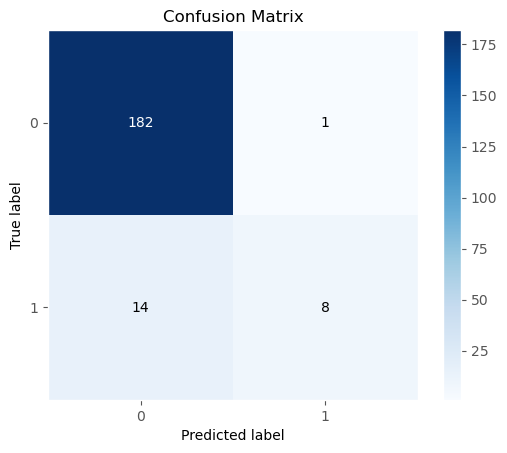

In [75]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Feature Scaling - for SVM & Logistic Regression

In [76]:
# Standard processing
sc = StandardScaler()
X.drop(['age_bin'], axis=1, inplace=True)
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


C:\Users\colle\AppData\Local\Temp\ipykernel_26928\2389235515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['age_bin'], axis=1, inplace=True)


# SVM

In [77]:
svc = svm.SVC(
    C=5,
    kernel="rbf",
    degree=3,
    gamma="auto",
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape="ovr",
    random_state=None,
)
model = svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)


In [78]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       186
           1       0.64      0.37      0.47        19

    accuracy                           0.92       205
   macro avg       0.79      0.67      0.71       205
weighted avg       0.91      0.92      0.91       205



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

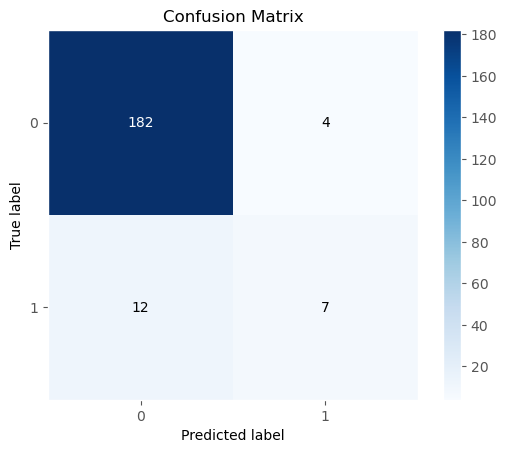

In [79]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Logistic Regression

In [82]:
lr = LogisticRegression(C=1).fit(X_train, y_train)
y_pred = lr.predict(X_test)


In [83]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       186
           1       0.64      0.47      0.55        19

    accuracy                           0.93       205
   macro avg       0.80      0.72      0.75       205
weighted avg       0.92      0.93      0.92       205



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

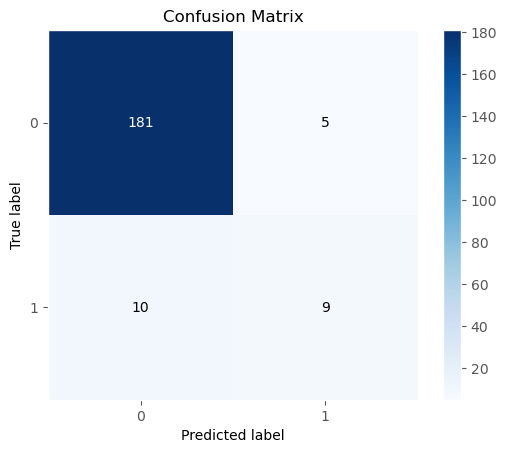

In [84]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


# Try: Use only two features **to plot Decision Boundary

In [85]:
def plot_decision_boundary(model, X, y):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    xticks = np.linspace(X_min[0], X_max[0], 100)
    yticks = np.linspace(X_min[1], X_max[1], 100)
    xx, yy = np.meshgrid(xticks, yticks)
    ZZ = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = ZZ >= 0.5
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax = plt.gca()
    ax.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha=0.6)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, alpha=0.6)


In [93]:
X = df[["min_balance_befroe_loan", "times_balance_below_5K", 'amount']]
y = df["status"]


In [94]:
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion="gini",
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)

X_train, X_test, y_train, y_test = train_test_split(X, y)
final_model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_pred, y_test)
f1


c:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.5185185185185185

In [95]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       151
           1       1.00      0.35      0.52        20

    accuracy                           0.92       171
   macro avg       0.96      0.68      0.74       171
weighted avg       0.93      0.92      0.91       171



<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

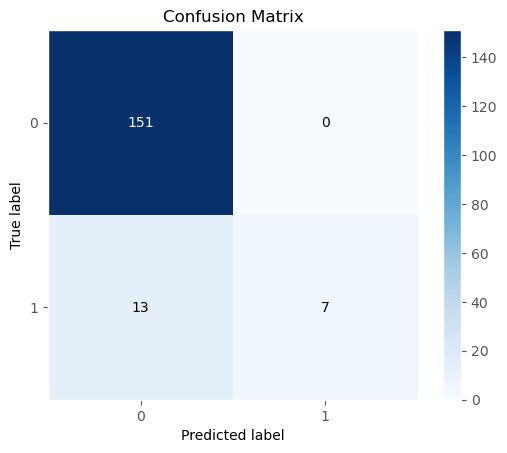

In [96]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


c:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'times_balance_below_5K')

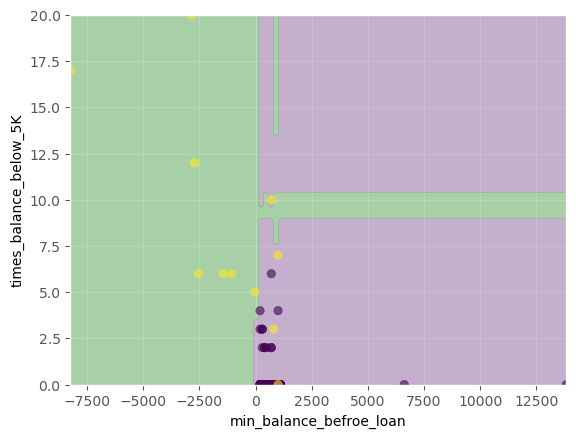

In [97]:
plot_decision_boundary(model, X_test, y_test)
plt.xlabel("min_balance_befroe_loan")
plt.ylabel("times_balance_below_5K")


<Axes: xlabel='feature'>

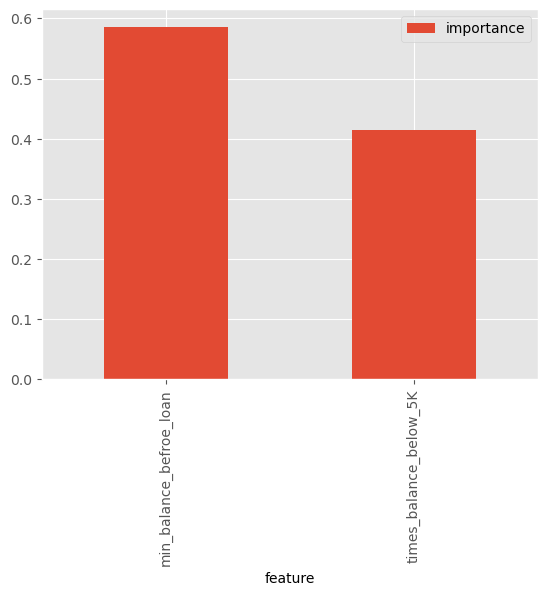

In [91]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")


# Conclusion
In the bank loan default prediction, my assumption is banks want to control the loss to a acceptable level, without missing some good client. This means balance the customers be grouped as potential good/bad customers, and their profiles will be checked carefully. 
Banks can detect the default behaviours in the earlier stage and conduct the corresponding actions to reduce the possible loss. That's why all of the new features I created are only based on the dates of the transfer must before the date that client apply for a loan.

In [92]:
df.to_csv("dataset.csv")